In [1]:
!pip install yfinance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 62 kB 653 kB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0


In [2]:
import math
import yfinance as yf
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler 
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

stock_data = yf.download('TCS', start='2020-01-01', end='2022-10-31')
stock_data.head()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-01-02,4.29,4.37,4.17,4.27,3.991522,142800
2020-01-03,4.22,4.32,4.18,4.28,4.000870,141500
2020-01-06,4.23,4.46,4.20,4.45,4.159782,118500
2020-01-07,4.44,4.45,4.31,4.39,4.103695,104500
2020-01-08,4.36,4.45,4.33,4.34,4.056957,213400


In [3]:
stock_data

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-01-02,4.29,4.37,4.17,4.27,3.991522,142800
2020-01-03,4.22,4.32,4.18,4.28,4.000870,141500
2020-01-06,4.23,4.46,4.20,4.45,4.159782,118500
2020-01-07,4.44,4.45,4.31,4.39,4.103695,104500
2020-01-08,4.36,4.45,4.33,4.34,4.056957,213400
...,...,...,...,...,...,...
2022-10-24,5.17,5.25,5.06,5.08,5.080000,927200
2022-10-25,5.11,5.41,5.07,5.38,5.380000,2069000
2022-10-26,5.36,5.76,5.36,5.49,5.490000,403200


Text(0, 0.5, 'Prices ($)')

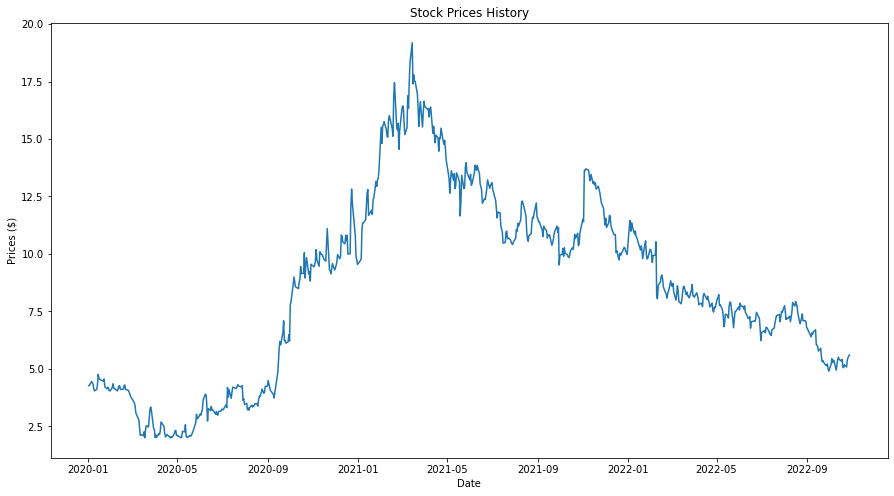

In [4]:
plt.figure(figsize=(15, 8))
plt.title('Stock Prices History')
plt.plot(stock_data['Close'])
plt.xlabel('Date')
plt.ylabel('Prices ($)')

In [5]:
close_prices = stock_data['Close']
values = close_prices.values
training_data_len = math.ceil(len(values)* 0.8)

scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(values.reshape(-1,1))

train_data = scaled_data[0: training_data_len, :]

x_train = []
y_train = []

for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i, 0])
    
x_train, y_train = np.array(x_train), np.array(y_train)

x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

In [6]:
x_train.shape

(511, 60, 1)

In [7]:
test_data = scaled_data[training_data_len-60: , : ]
x_test = []
y_test = values[training_data_len:]

for i in range(60, len(test_data)):
  x_test.append(test_data[i-60:i, 0])

x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

In [8]:
model = keras.Sequential()
model.add(layers.LSTM(200, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(layers.LSTM(200, return_sequences=False))
model.add(layers.Dense(100))
model.add(layers.Dense(1))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 60, 200)           161600    
                                                                 
 lstm_1 (LSTM)               (None, 200)               320800    
                                                                 
 dense (Dense)               (None, 100)               20100     
                                                                 
 dense_1 (Dense)             (None, 1)                 101       
                                                                 
Total params: 502,601
Trainable params: 502,601
Non-trainable params: 0
_________________________________________________________________


In [9]:
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(x_train, y_train, batch_size= 1, epochs=5)

Epoch 1/5
511/511 [==============================] - 17s 9ms/step - loss: 0.0063
Epoch 2/5
511/511 [==============================] - 5s 9ms/step - loss: 0.0026
Epoch 3/5
511/511 [==============================] - 5s 9ms/step - loss: 0.0019
Epoch 4/5
511/511 [==============================] - 5s 9ms/step - loss: 0.0016
Epoch 5/5
511/511 [==============================] - 5s 9ms/step - loss: 0.0014


In [10]:
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)
rmse = np.sqrt(np.mean(predictions - y_test)**2)
rmse

5/5 [==============================] - 1s 8ms/step


0.08285565443441902

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


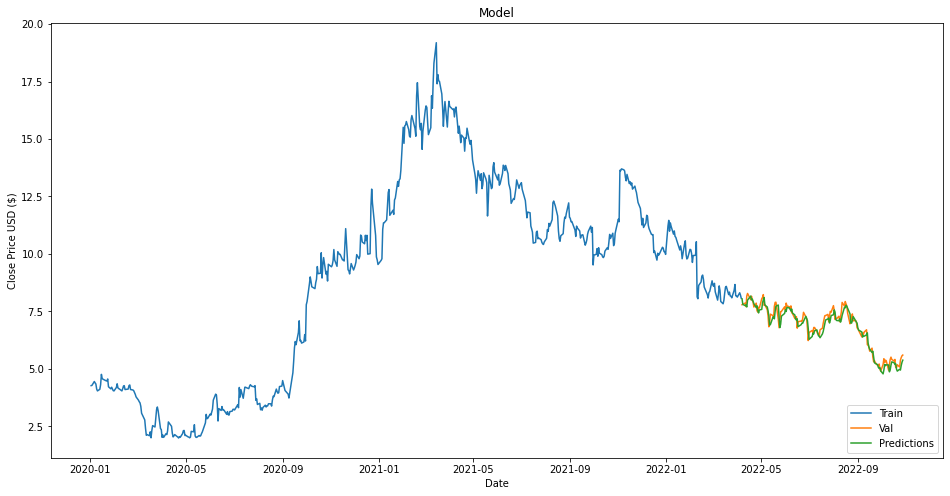

In [11]:
data = stock_data.filter(['Close'])
train = data[:training_data_len]
validation = data[training_data_len:]
validation['Predictions'] = predictions
plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date')
plt.ylabel('Close Price USD ($)')
plt.plot(train)
plt.plot(validation[['Close', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()